In [1]:
using DataFrames, DataFramesMeta, JSON, Statistics
#using StatsPlots
using GLM
#gr()
using AlgebraOfGraphics, AbstractPlotting, CairoMakie
using AlgebraOfGraphics: linear, smooth

In [2]:
inp = []
for fname in readdir()
    name, ext = splitext(fname)
    if ext == ".json"
        fields = split(fname, '_')
        if fields[1] == "poisson" || fields[1] == "constant"
            j = JSON.parsefile(fname; dicttype=Dict, inttype=Int64)
            push!(inp, (fields, j, name))
        end
    end
end

In [3]:
df = DataFrame(
    name = String[],
    arrival_type = String[],
    arrival_rate = Int[],
    vehicles = Int[],
    time_windows = Int[],
    locations = Int[],
    policy = String[],
    day = Int[],
    packages = Int[],
    avg_days_taken = Float64[],
    total_distance = Int[],
    total_time = Int[],
    deliveries = Int[],
    attempted_deliveries = Int[]
)
for v in inp
    for record in v[2]
        push!(df, (
            v[3],
            v[1][1],
            parse(Int, v[1][2]),
            parse(Int, v[1][3]),
            parse(Int, v[1][4]),
            parse(Int, v[1][5]),
            v[1][6],
            record["day"],
            record["number_of_packages"],
            mean(record["delivered_packages"]["days_taken"]),
            sum(record["distances"]),
            sum(record["times"]),
            length(record["delivered_packages"]["days_taken"]),
            sum(record["deliveries_attempted"]),
        ))
    end
end
df

,name,arrival_type,arrival_rate,vehicles,time_windows
,String,String,Int64,Int64,Int64
1,poisson_50_3_1_1_wait_policy_collection,poisson,50,3,1
2,poisson_50_3_1_1_wait_policy_collection,poisson,50,3,1
3,poisson_50_3_1_1_wait_policy_collection,poisson,50,3,1
4,poisson_50_3_1_1_wait_policy_collection,poisson,50,3,1
5,poisson_50_3_1_1_wait_policy_collection,poisson,50,3,1
6,poisson_50_3_1_1_wait_policy_collection,poisson,50,3,1
7,poisson_50_3_1_1_wait_policy_collection,poisson,50,3,1
8,poisson_50_3_1_1_wait_policy_collection,poisson,50,3,1
9,poisson_50_3_1_1_wait_policy_collection,poisson,50,3,1


The priority in any delivery system is to ensure that packages actually get delivered. So lets look at how the number of packages evolves over time.

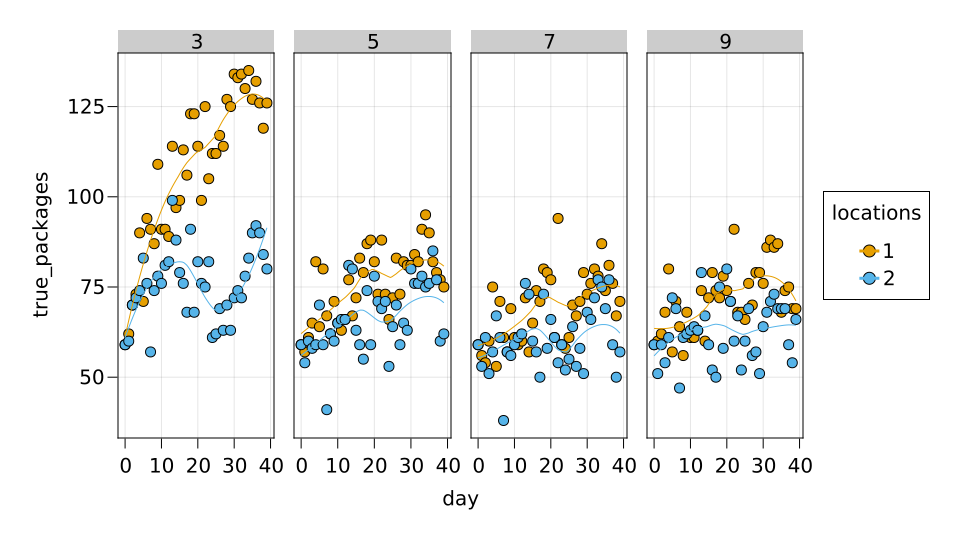

┌ Warning: Showing scene as text. This happens because `AbstractPlotting.inline!(true)` is set.
│ This needs to be false to show a plot in a window when in the REPL.
└ @ AbstractPlotting /home/michael/.julia/packages/AbstractPlotting/T806p/src/display.jl:135


In [6]:
q = @linq df |>
    transform(true_packages = :packages ./ :locations) |>
    where(:day .>= 0)
cols = style(:day, :true_packages)
scat = spec(Scatter)
pipeline2 = cols * scat

grp = style(layout_x = :vehicles => categorical , color = :locations => categorical)
data(q) * cols * grp * (scat + smooth(span = 0.8)) |> draw

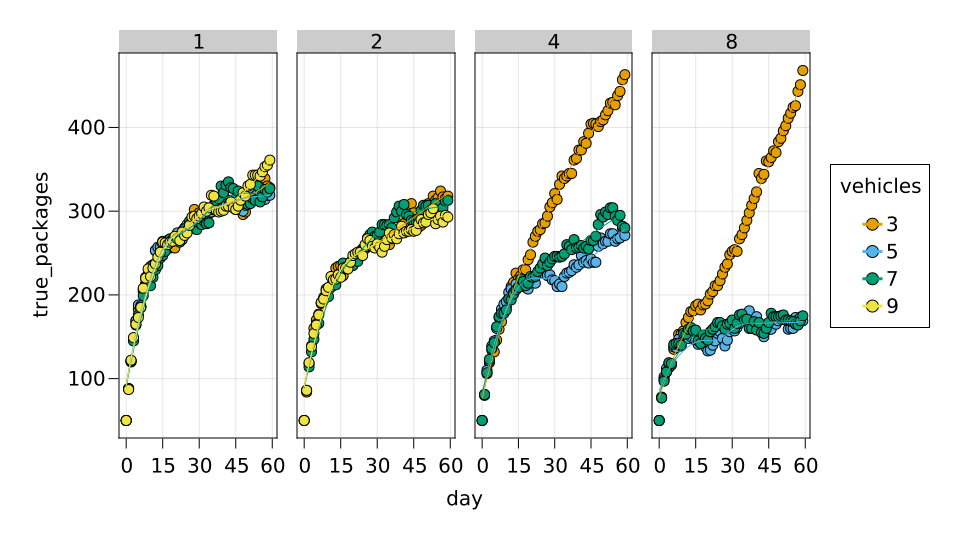

┌ Warning: Showing scene as text. This happens because `AbstractPlotting.inline!(true)` is set.
│ This needs to be false to show a plot in a window when in the REPL.
└ @ AbstractPlotting /home/michael/.julia/packages/AbstractPlotting/T806p/src/display.jl:135


In [12]:
q = @linq df |>
    transform(true_packages = :packages ./ :locations) |>
    where(:day .>= 0) |> 
    where(:arrival_type .== "constant") |>
    where(:locations .== 2)
cols = style(:day, :true_packages)
scat = spec(Scatter)
pipeline2 = cols * scat

grp = style(layout_x = :time_windows => categorical, color = :vehicles => categorical)
data(q) * cols * grp * (scat + smooth(span = 0.8)) |> draw

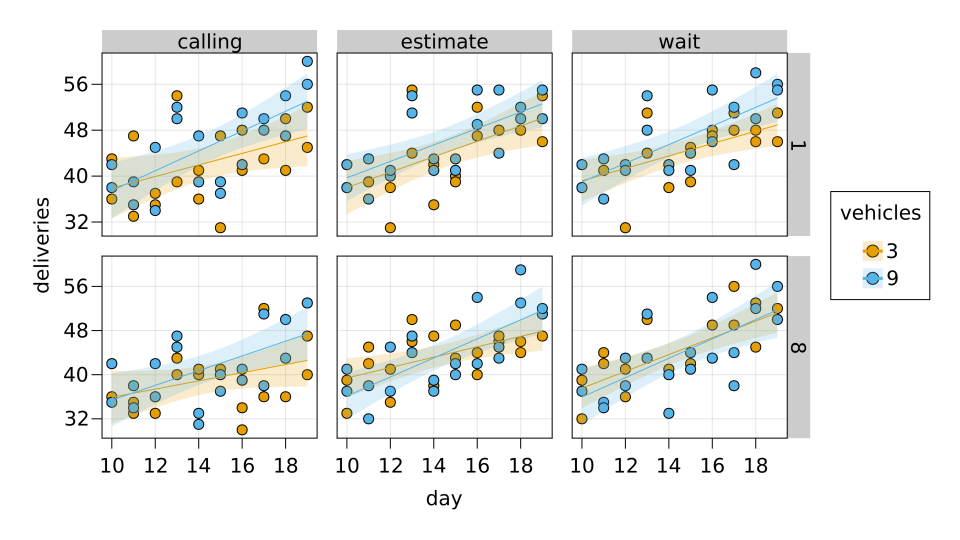

┌ Warning: Showing scene as text. This happens because `AbstractPlotting.inline!(true)` is set.
│ This needs to be false to show a plot in a window when in the REPL.
└ @ AbstractPlotting /home/michael/.julia/packages/AbstractPlotting/T806p/src/display.jl:135


In [36]:
q = @linq df |>
    transform(true_packages = :packages ./ :locations) |>
    where(:day .>= 10) |> 
    where(:arrival_type .== "poisson") |>
    where(:locations .== 1)
cols = style(:day, :deliveries)
scat = spec(Scatter)
pipeline2 = cols * scat

grp = style(layout_x = :policy, layout_y = :time_windows => categorical, color = :vehicles => categorical)
data(q) * cols * grp * (scat + linear) |> draw1

We can see that most of the strategies have somewhat reached a steady state, delivering most of the incoming packages. There are some that are continuing to increase, so lets look at those in more detail:

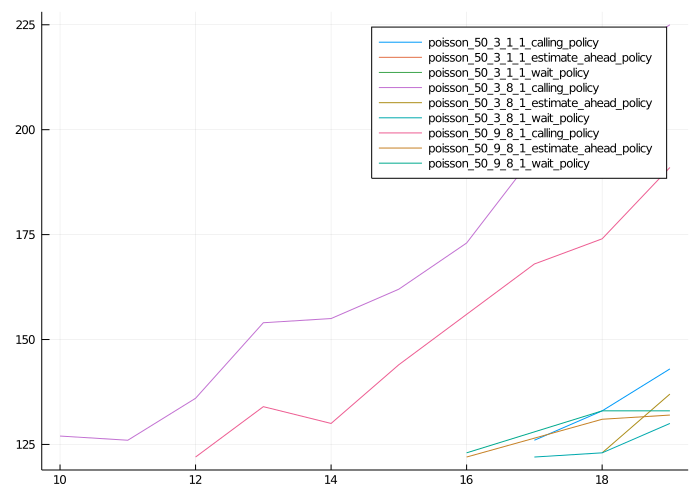

In [41]:
gr(size=(700,500))

@df (@linq df |> 
    where(:arrival_type .== "poisson") |>
    where(:day .>= 10) |> 
    where(:packages./:locations .> 120)
) plot(
    :day, :packages ./ :locations, group = :name
)

In [ ]:
Well, that's unsurprising. The two runs that did very poorly are both call-ahead policies with 8 time_windows and only one location per customer. In fact, all policies did poorly with 8 and 1; calling just did much worse.



In [45]:
@df (@linq df |>
    where(:arrival_type .== "poisson") |>
    where(:day .>= 13) |>
    where(:policy .== "calling") |>
    by([:vehicles, :time_windows, :locations, :policy], y = maximum(:packages ./ :locations))
) plot(linear, :vehicles, :y, group=:locations)

LoadError: UndefVarError: linear not defined

Number of deliveries by locations


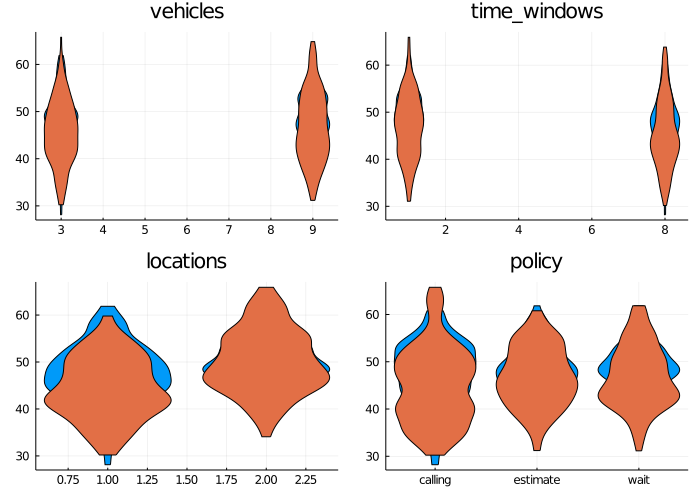

In [36]:
q = @linq df |>
    where(:day .> 10) |>
    #by([:vehicles, :time_windows, :locations, :policy], y = maximum(:deliveries)) |>
    where(:vehicles .> 0) |>
    where(:time_windows .> 0) |>
    where(:locations .> 0)
a = @df q violin(:vehicles, :deliveries, group=:arrival_type, title="vehicles", legend=nothing)
b = @df q violin(:time_windows, :deliveries, group=:arrival_type, title="time_windows", legend=nothing)
c = @df q violin(:locations, :deliveries, group=:arrival_type, title="locations", legend=nothing)
d = @df q violin(:policy, :deliveries,group=:arrival_type, title="policy", legend=nothing)
println("Number of deliveries by locations")
plot(a,b,c,d)

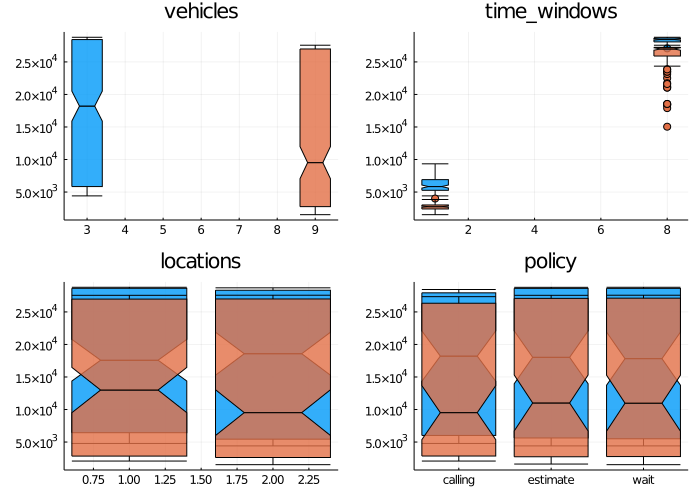

In [28]:
q = @linq df |>
    where(:arrival_type .== "constant") |>
    #by([:vehicles, :time_windows, :locations, :policy], y = mean(:deliveries)) |>
    where(:vehicles .> 0) |>
    where(:time_windows .> 0) |>
    where(:locations .> 0)
a = @df q boxplot(:vehicles, :total_time ./ :vehicles, group=:vehicles, title="vehicles", legend=nothing, notch=true, fillalpha = 0.8)
b = @df q boxplot(:time_windows, :total_time ./ :vehicles, group=:vehicles, title="time_windows", legend=nothing, notch=true, fillalpha = 0.8)
c = @df q boxplot(:locations, :total_time ./ :vehicles, group=:vehicles, title="locations", legend=nothing, notch=true, fillalpha = 0.8)
d = @df q boxplot(:policy, :total_time ./ :vehicles,group=:vehicles, title="policy", legend=nothing, notch=true, fillalpha = 0.8)
plot(a,b,c,d)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

total_distance ~ 1 + policy

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────
                            Coef.  Std. Error      t  Pr(>|t|)        Lower 95%       Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)             1.56626e6     85417.0  18.34    <1e-63        1.39863e6       1.73388e6
policy: estimate   -91508.4          120798.0  -0.76    0.4489  -328568.0        145551.0
policy: wait      -128003.0          120798.0  -1.06    0.2896  -365062.0        109056.0
───────────────────────────────────────────────────────────────────────────────────────────────

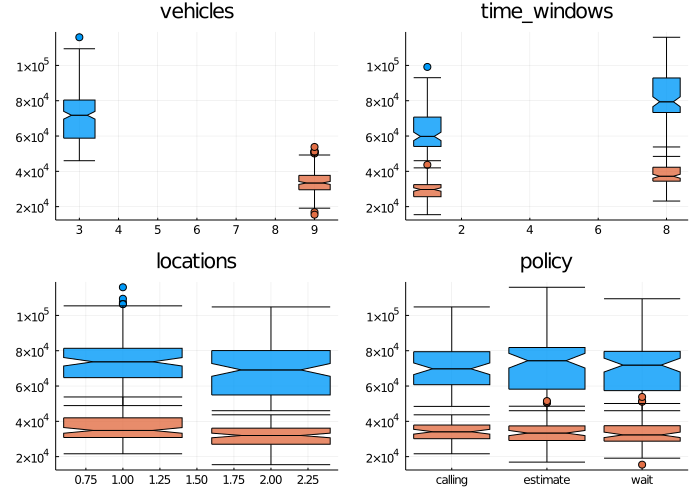

In [40]:
q = @linq df |>
    where(:arrival_type .== "constant") |>
    #by([:vehicles, :time_windows, :locations, :policy], y = mean(:deliveries)) |>
    where(:vehicles .> 0) |>
    where(:time_windows .> 0) |>
    where(:locations .> 0)
a = @df q boxplot(:vehicles, :total_distance ./ :vehicles, group=:vehicles, title="vehicles", legend=nothing, notch=true, fillalpha = 0.8)
b = @df q boxplot(:time_windows, :total_distance ./ :vehicles, group=:vehicles, title="time_windows", legend=nothing, notch=true, fillalpha = 0.8)
c = @df q boxplot(:locations, :total_distance ./ :vehicles, group=:vehicles, title="locations", legend=nothing, notch=true, fillalpha = 0.8)
d = @df q boxplot(:policy, :total_distance ./ :vehicles,group=:vehicles, title="policy", legend=nothing, notch=true, fillalpha = 0.8)

m = lm(@formula(total_distance ~ policy), df)
display(m)
plot(a,b,c,d)

In [41]:
using SimpleANOVA

┌ Info: Precompiling SimpleANOVA [fff527a3-8410-504e-9ca3-60d5e79bb1e4]
└ @ Base loading.jl:1278


In [31]:
m = lm(@formula(total_distance ~ vehicles), df)
m

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

total_distance ~ 1 + vehicles

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                       Coef.  Std. Error      t  Pr(>|t|)        Lower 95%       Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)        2.23945e6    106938.0  20.94    <1e-79        2.02959e6       2.44931e6
vehicles     -124394.0           15941.3  -7.80    <1e-13  -155678.0        -93109.7
──────────────────────────────────────────────────────────────────────────────────────────

In [80]:
q = @linq df |>
    where(:arrival_type .== "constant")
res = anova(q, :total_distance, [:policy, :locations, :time_windows])
res


Analysis of Variance Results

                           Effect          SS   DF          MS            F            p           ω²
-----------------------------------------------------------------------------------------------------
                            Total  2.47878e12  479                                                   
                     time_windows  5.5849e11     1  5.5849e11   170.18       2.14776e-33   0.223688  
                        locations  1.08965e11    1  1.08965e11   33.203      1.50716e-8    0.0425787 
                           policy  4.49778e8     2  2.24889e8     0.0685267  0.933778     -0.00246318
         time_windows × locations  1.20089e10    1  1.20089e10    3.65929    0.0563674     0.0035161 
            time_windows × policy  5.80599e10    2  2.90299e10    8.84581    0.000169491   0.0207474 
               locations × policy  2.03405e11    2  1.01703e11   30.9901     2.29487e-13   0.0793056 
time_windows × locations × policy  1.53279e9     2 

In [16]:
q

,name,arrival_type,arrival_rate,vehicles,time_windows
,String,String,Int64,Int64,Int64
1,experiments_50_3_1_1_wait_policy,experiments,50,3,1
2,experiments_50_3_1_1_wait_policy,experiments,50,3,1
3,experiments_50_3_1_1_wait_policy,experiments,50,3,1
4,experiments_50_3_1_1_wait_policy,experiments,50,3,1
5,experiments_50_3_1_1_wait_policy,experiments,50,3,1
6,experiments_50_3_1_1_wait_policy,experiments,50,3,1
7,experiments_50_3_1_1_wait_policy,experiments,50,3,1
8,experiments_50_3_1_1_wait_policy,experiments,50,3,1
9,experiments_50_3_1_1_wait_policy,experiments,50,3,1


In [49]:
data = AlgebraOfGraphics.data

data (generic function with 1 method)